# Introducción

El objetivo principal de esta actividad es estudiar la capacidad de generalización de las Redes Neuronalea Artificiales supervisadas, en concreto veremos el modelo [Learning Vector Quantization][lvq_wikipedia] (LVQ) aplicado sobre el problema de reconcimiento de dígitos escritos a mano a partir de los datos publicados en el UCI Machine Learning Repository (Lichman, 2003) denominado [Optical Recognition of Handwritten Digits Data Set][uci_ocrhdds]. Utilizaremos la [implementación del LVQ que provee Neurolab][nl_lvqcode], que muestran también [un ejemplo de su uso][nl_lvqexample].

Puede aprender algo más acerca de LVQ leyendo [esta presentación][lvq_slides].

* (Lichman, 2003) Lichman, M. (2013). [UCI Machine Learning Repository][uci_repo]. Irvine, CA: University of California, School of Information and Computer Science. 

[lvq_wikipedia]: http://en.wikipedia.org/wiki/Learning_vector_quantization
[uci_repo]: http://archive.ics.uci.edu/ml
[uci_ocrhdds]: http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits
[nl_lvqcode]: https://github.com/omtinez/neurolab/blob/master/neurolab/train/lvq.py
[nl_lvqexample]: https://pythonhosted.org/neurolab/ex_newlvq.html
[lvq_slides]: https://es.slideshare.net/mentelibre/learning-vector-quantization-lvq

# Inicialización de Python

In [1]:
!python -m pip install neurolab --user

import numpy as np
import neurolab as nl
import pylab as pl

# Conjuntos de patrones empleados
Se cargan los patrones de entrenamiento en memoria, se barajean y se generan las salidas deseadas con formato de 10 salidas binarias. Se divide el conjunto original barajeado en un 75% para entrenar y un 25% para validar. Finalmente se visualizan algunos de los patrones. El código necesario para todo ello es el siguiente:

In [2]:
# Leer fichero de patrones de entrenamiento
patterns = np.loadtxt("optdigits.tra", dtype=int, delimiter=',')

# Dimensiones leidas
totpat, totcols = patterns.shape

(totpat, totcols)

(3823, 65)

In [3]:
# Barajar los patrones
np.random.seed(seed=0)
np.random.shuffle(patterns)

# Generar salidas deseada con formato 10 salidas binarias
target = np.zeros([totpat, 10])
for i in range(totpat):
    target[i, patterns[i, -1]] = 1.0

# Dividir patrones en cto entrenamiento y cto validación
ratiotrain = 0.75    # 75% en entrenamiento, 25% validación
tottrain = int(np.floor(ratiotrain * totpat))
totvalid = totpat - tottrain

(tottrain, totvalid)

(2867, 956)

In [4]:
# Preparar vectores de entradas y salidas deseadas
traininput = patterns[0:tottrain, 0:totcols-1]
traintarget = target[0:tottrain, :]

validinput  = patterns[tottrain:, 0:totcols-1]
validtarget  = target[tottrain:, :]

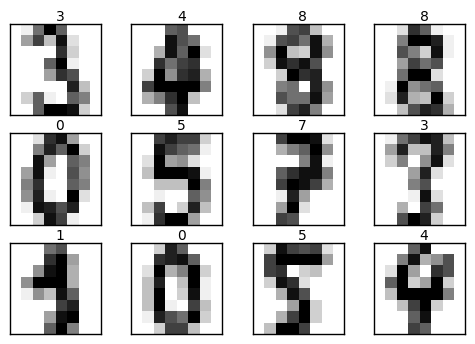

In [5]:
# Visluaizar algunos patrones ejemplos
for i in range(12):
    pl.subplot(3, 4, 1 + i)
    imgplot = pl.imshow(16 - traininput[i,:].reshape(8,8))
    imgplot.set_interpolation('nearest')
    imgplot.set_cmap('gray')
    pl.text(3.5, -0.8, int(np.dot(traintarget[i], np.arange(10))))
    pl.xticks([],[])
    pl.yticks([],[])

pl.show()

# Modelo de RNA y parámetros 
El modelo de RNA a utilizar será el [Learning Vector Quantization (LVQ)][lvq_wikipedia]. Se trata de un modelo supervisado de dos capas, la primera o capa ocultas es de aprendizaje competitivo, la segunda capa se utiliza para etiquetar los prototipos de la capa anterior a las clases finales, normalmente es un perceptron simple o similar. El aprendizaje consiste básicamente en, si la red clasifica correctamente un patrón, acercar el prototipo ganador a ese patrón, si la red lo clasifica incorrectamente lo alejaría.

La [implementación de LVQ por Neurlab][nl_lvqexample] es bastante simple. Los prototipos se inicializan todos al promedio de los rangos dados para las entradas. El número de neuronas ocultas se reparte proporcionalmente entre las clases de salida según unos coeficientes dados. El ratio de aprendizaje es fijo durante todos los ciclos y dispone de dos modos de entrenamiento (parámetro adapt), por ciclos y modo batch, aunque en este último parece haber un bug en el [código][nl_lvqcode]. La mayor debilidad que vemos en esta implementación es la inicialización de prototipos, como se comentará, se ha realizado una nueva inicialización asgnándolos a patrones aleatorios de su clase que nos ofrece mejores resultados.

El parámetro principal a estudiar es el número de neuronas ocultas, además se prueba con distintas semillas para el generador de números aletaorios para generar inicializaciones diferentes. También se han probado distintos valores para el ratio de aprendizaje, no obteniendo grandes diferencias y dejando su valor por defecto a 0,004.

[lvq_wikipedia]: http://en.wikipedia.org/wiki/Learning_vector_quantization
[uci_ocrhdds]: http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits
[nl_lvqcode]: https://github.com/omtinez/neurolab/blob/master/neurolab/train/lvq.py
[nl_lvqexample]: https://pythonhosted.org/neurolab/ex_newlvq.html

## Resultados iniciales
En primer lugar se crea una red LVQ con 60 neuronas ocultas, un promedio de 6 neuronas para representar cada clase. Usando la propia inicialización del LVQ de NeuroLab se entrena y calculan los errores obtenidos. El código necesario para ello es:

In [6]:
# Crear red LVC 64 entradas en rango 0..16, 60 neuronas ocultas y 10 salidas
nh = 60
lr = 0.004
minmax = np.vstack((np.zeros(totcols - 1, dtype=int), np.ones(totcols - 1, dtype=int) * 16)).transpose()
pc = np.asfarray(np.ones(10) * 0.1)
pc[-1] = pc[-1] + (1 - sum(pc))       # Trick para evitar err redondeo
net = nl.net.newlvq(minmax, nh, pc)

# Entrenar durante 100 ciclos y validar cada 5
error = np.array([])
errorvalid = []
out = net.sim(validinput)
errorvalid = [((validtarget - out)**2).sum() / totvalid / 10]
validcicles = 5
for i in range(100/validcicles):
    error10 = net.train(traininput, traintarget, epochs=validcicles, show=validcicles, goal=-1, lr=lr)
    error = np.hstack((error, error10))
    out = net.sim(validinput)
    errorvalid.append(((validtarget - out)**2).sum() / totvalid / 10)

# Salvar red a fichero
net.save("optdigits.net")

Epoch: 5; Error: 0.0652249738403;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0479246599233;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0482036972445;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0479246599233;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0474363446111;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0299965120335;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0288803627485;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0288803627485;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0289501220788;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0289501220788;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0288803627485;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0289501220788;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0289501220788;
The ma

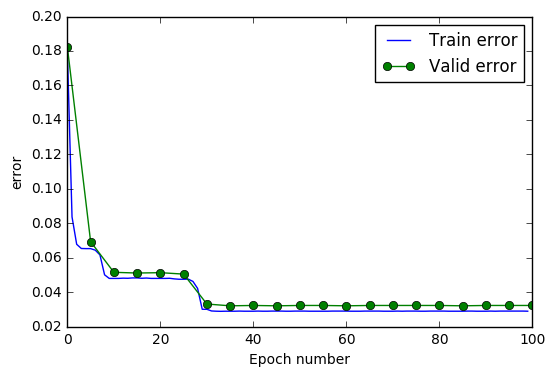

In [7]:
# Impresión del error vs ciclos
pl.plot(error, label='Train error')
pl.plot(range(0,101,validcicles), errorvalid, '-o', label='Valid error')
pl.xlabel('Epoch number')
pl.ylabel('error')
pl.legend(loc='upper right')
pl.show()

Como se ve, los errores MSE van disminuyendo en escalones. Calculamos a continuación los errores en tanto por ciento, las matrices de cruces y visualizamos los prototipos generados.

In [8]:
# Cálculo de errores en %
outtrain = net.sim(traininput)
outvalid = net.sim(validinput)

rerrtrain = (((traintarget - outtrain)**2).max(axis=1)).sum() / tottrain
errvalid = ((validtarget - outvalid)**2).max(axis=1)
rerrvalid = errvalid.sum() / totvalid

print "Train error:", rerrtrain * 100, "%"
print "Validation error:", rerrvalid * 100, "%"

Train error: 14.4401813743 %
Validation error: 16.1087866109 %


In [9]:
# Crear matrices de cruces del conjunto de entrenamiento
matcrutrain = np.zeros(100, dtype=int).reshape(10,10)
for i in range(tottrain):
    matcrutrain[int(np.dot(traintarget[i], np.arange(10))), int(np.dot(outtrain[i], np.arange(10)))] += 1

matcrutrain

array([[287,   0,   0,   0,   2,   0,   1,   0,   1,   0],
       [  1, 286,  11,   2,   0,   0,   4,   2,   8,   0],
       [  5,   0, 266,   1,   0,   0,   1,   4,   9,   0],
       [  1,   1,   0, 273,   0,   4,   0,   1,   3,   0],
       [  0,   6,   0,   0, 256,   2,   5,  12,   2,   0],
       [  0,   0,   6,   3,   0, 264,   1,   0,   0,   0],
       [  0,   3,   0,   0,   1,   0, 280,   0,   0,   0],
       [  0,   2,   0,   0,   0,   0,   0, 286,   3,   0],
       [  0,  11,   1,   2,   2,   3,   5,   0, 255,   0],
       [ 39,  23,  10,  78,  21,  53,   1,  23,  34,   0]])

In [10]:
# Crear matrices de cruces del conjunto de validación
matcruvalid = np.zeros(100, dtype=int).reshape(10,10)
for i in range(totvalid):
    matcruvalid[int(np.dot(validtarget[i], np.arange(10))), int(np.dot(outvalid[i], np.arange(10)))] += 1

matcruvalid

array([[85,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 66,  2,  0,  0,  0,  0,  0,  6,  0],
       [ 1,  0, 83,  1,  0,  0,  0,  1,  8,  0],
       [ 0,  1,  2, 94,  0,  2,  0,  2,  5,  0],
       [ 0,  3,  0,  0, 93,  0,  0,  2,  6,  0],
       [ 1,  0,  0,  1,  1, 98,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 93,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  0, 94,  0,  0],
       [ 0,  4,  0,  0,  0,  0,  1,  0, 96,  0],
       [ 7,  4,  2, 36,  9, 22,  0, 11,  9,  0]])

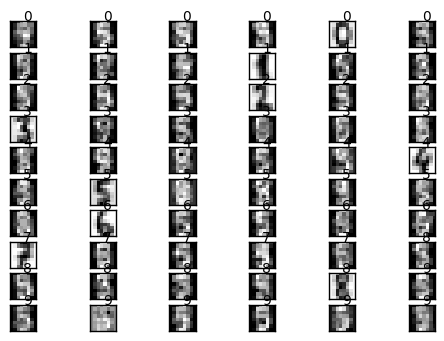

In [11]:
# Visualizar prototipos 
prototipos = net.layers[0].np['w']
clases = net.layers[1].np['w']

for i in range(nh):
    pl.subplot(10, int(np.ceil(nh/10)), 1 + i)
    imgplot = pl.imshow(16 - prototipos[i,:].reshape(8,8))
    imgplot.set_interpolation('nearest')
    imgplot.set_cmap('gray')
    pl.text(3.5, -0.8, int(np.where(clases[:,i] == 1)[0][0]))
    pl.xticks([],[])
    pl.yticks([],[])

pl.show()

Se aprecia que los porcentajes de errores de entrenamiento y validación son bastante altos (14,4% y 16,1%). Además en las matrices de cruces se observa que la clase correspondiente al número '9' no dispara ninguna vez, no se consigue converger adecuadamente. La visualización de los prototipos muestra que solo se está usando sólo 1 prototipo por clase (los de fondo blanco) de los 6 para cada clase desde la '0' a la '8', la clase '9' no tiene ninguno. El resto de prototipos han sido alejados. Otro problema detectado en la implementación de LVQ del NeuroLab es que la distribución de los prototipos por clase no es del todo correcta, ya que a la clase '7' se le han asignado 5 prototipos y a la clase '9' se le han asignado 7, cuando deberían haber sido 6 para todas las clases.

Creemos que la inicialización de los prototipos al promedio de los rangos de entrada (8) impide que la capa competitiva se diversifique y expanda correctamente por el espacio de entrada. Para solventar este problema crearemos una nueva inicialización de prototipos asignándolos a patrones del conjunto de entrenamiento elegidos aleatoriamente entre aquellos pertenecientes a la clase del prototipo. El código necesario para ello se muestra a continuación:

In [12]:
# Función de inicialización red LVQ con patrones de entrenamiento
def initlvq_randpat(net, input, target, seed=None):
    """
    Inicializar red lvq asignado prototipos a patrones
    aleatorios de esa misma clase
    """
    
    prototipos = net.layers[0].np['w']
    clases = net.layers[1].np['w']
    np.random.seed(seed=seed)

    for i in range(len(prototipos[:,0])):

        # Buscar clase del prototipo
        clase = int(np.where(clases[:,i] == 1)[0][0])
        # Buscar indices patrones de esa clase
        indspatclase = np.where(traintarget[:,clase] == 1)[0]
        # Elegir y copiar aleatoriamente uno de ellos como prototipo
        indpat = indspatclase[np.random.random_integers(0, len(indspatclase)-1)]
        prototipos[i,:] = traininput[indpat,:].copy()

Con la red inicializada de esta forma volvemos a entrenar nuevamente y mostrar los resultados obtenidos:

In [13]:
# Inicializar red con patrones de entrenamiento
initlvq_randpat(net, traininput, traintarget, 0)

# Entrenar durante 100 ciclos y validar cada 5
error = np.array([])
errorvalid = []
out = net.sim(validinput)
errorvalid = [((validtarget - out)**2).sum() / totvalid / 10]
validcicles = 5
for i in range(100/validcicles):
    error10 = net.train(traininput, traintarget, epochs=validcicles, show=validcicles, goal=-1, lr=lr)
    error = np.hstack((error, error10))
    out = net.sim(validinput)
    errorvalid.append(((validtarget - out)**2).sum() / totvalid / 10)

# Salvar red a fichero
net.save("optdigitsi.net")

Epoch: 5; Error: 0.00955702825253;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.00683641437042;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.00606906173701;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.00585978374608;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.00530170910359;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0053714684339;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.00516219044297;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.00481339379142;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.0046738751308;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.00460411580049;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.00446459713987;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.00439483780956;
The maximum number of train epochs is reached
Epoch: 5; Error: 0.00453435647

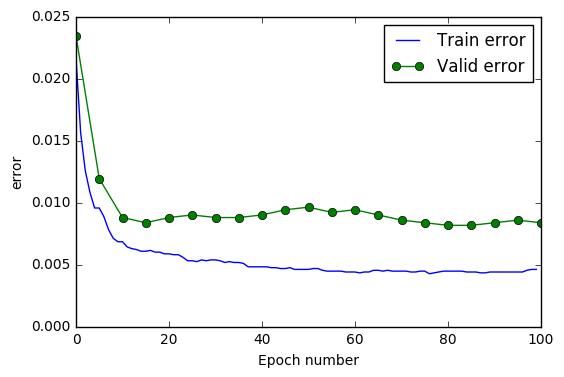

In [14]:
# Impresión del error vs ciclos
pl.plot(error, label='Train error')
pl.plot(range(0,101,validcicles), errorvalid, '-o', label='Valid error')
pl.xlabel('Epoch number')
pl.ylabel('error')
pl.legend(loc='upper right')
pl.show()

 Como se aprecia ahora el error MSE disminuye de forma más gradual, alcanzando un valor un orden de magnitud menor que anteriormente.

In [15]:
# Cálculo de errores en %
outtrain = net.sim(traininput)
outvalid = net.sim(validinput)

rerrtrain = (((traintarget - outtrain)**2).max(axis=1)).sum() / tottrain
errvalid = ((validtarget - outvalid)**2).max(axis=1)
rerrvalid = errvalid.sum() / totvalid

print "Train error:", rerrtrain * 100, "%"
print "Validation error:", rerrvalid * 100, "%"

Train error: 2.30205790024 %
Validation error: 4.18410041841 %


In [16]:
# Crear matrices de cruces del conjunto de entrenamiento
matcrutrain = np.zeros(100, dtype=int).reshape(10,10)
for i in range(tottrain):
    matcrutrain[int(np.dot(traintarget[i], np.arange(10))), int(np.dot(outtrain[i], np.arange(10)))] += 1

matcrutrain

array([[289,   0,   0,   0,   1,   0,   1,   0,   0,   0],
       [  0, 307,   3,   0,   0,   1,   0,   1,   0,   2],
       [  0,   1, 284,   0,   0,   0,   0,   0,   0,   1],
       [  0,   2,   0, 273,   0,   3,   0,   1,   1,   3],
       [  1,   0,   0,   0, 273,   0,   3,   1,   1,   4],
       [  0,   1,   0,   1,   0, 269,   0,   0,   0,   3],
       [  0,   2,   0,   0,   0,   1, 281,   0,   0,   0],
       [  0,   3,   1,   0,   0,   0,   0, 285,   0,   2],
       [  0,   6,   0,   0,   0,   0,   2,   0, 269,   2],
       [  0,   1,   0,   2,   2,   1,   0,   2,   3, 271]])

In [17]:
# Crear matrices de cruces del conjunto de validación
matcruvalid = np.zeros(100, dtype=int).reshape(10,10)
for i in range(totvalid):
    matcruvalid[int(np.dot(validtarget[i], np.arange(10))), int(np.dot(outvalid[i], np.arange(10)))] += 1

matcruvalid

array([[ 85,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  72,   0,   0,   0,   1,   0,   0,   0,   2],
       [  0,   0,  94,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 102,   0,   0,   0,   1,   2,   1],
       [  0,   1,   0,   0,  97,   0,   0,   1,   4,   1],
       [  0,   0,   0,   1,   0,  98,   0,   0,   0,   3],
       [  0,   0,   0,   0,   0,   0,  92,   0,   1,   0],
       [  0,   0,   0,   1,   1,   0,   0,  94,   0,   0],
       [  0,   8,   0,   0,   0,   0,   1,   0,  90,   2],
       [  0,   1,   0,   1,   2,   2,   0,   2,   0,  92]])

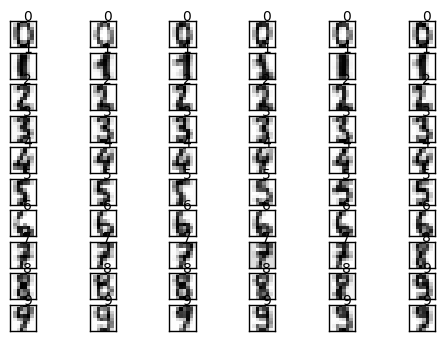

In [18]:
# Visualizar prototipos 
prototipos = net.layers[0].np['w']
clases = net.layers[1].np['w']

for i in range(nh):
    pl.subplot(10, int(np.ceil(nh/10)), 1 + i)
    imgplot = pl.imshow(16 - prototipos[i,:].reshape(8,8))
    imgplot.set_interpolation('nearest')
    imgplot.set_cmap('gray')
    pl.text(3.5, -0.8, int(np.where(clases[:,i] == 1)[0][0]))
    pl.xticks([],[])
    pl.yticks([],[])

pl.show()

Ahora los porcentajes de errores de entrenamiento y validación son mucho más bajos (2,3% y 4,2%). En las matrices de cruce todas las clases son clasificadas bastante bien. La visualización de los prototipos no muestra ninguno que haya sido alejado.

## Optimización de la arquitectura

En este estudio se trata de buscar la configuración de número de neuronas ocultas más adecuada, o sea, en la que se obtenga un menor error de validación. Para ello se realizan pruebas entre 2 y 10 neuronas ocultas por clase y repitiendo 10 veces cada red con distintas semillas aleatorias para la inicialización de prototipos, luego se muestran los resultados obtenidos. El código necesario para ello es el siguiente:

In [19]:
# Estudio con distintas neuronas ocultas (puede tardar bastante tiempo)
testsnh = [20, 30, 40, 50, 60, 70, 80, 90, 100]
res = np.zeros((2, (len(testsnh))))
for j, nh in enumerate(testsnh):
    # Crear red
    net = nl.net.newlvq(minmax, nh, pc)
    # Entrenar con distintas semillas para inicializador
    nreps = 10
    mins = np.zeros((2, nreps))
    for i in range(nreps):
        # Inicializar a patrones aleatorios
        initlvq_randpat(net, traininput, traintarget, i)
        error = net.train(traininput, traintarget, epochs=100, show=0, goal=-1, lr=lr)
        # Cálculo de errores
        outtrain = net.sim(traininput)
        errtrain = (((traintarget - outtrain)**2).max(axis=1)).sum() / tottrain
        outvalid = net.sim(validinput)
        errvalid = (((validtarget - outvalid)**2).max(axis=1)).sum() / totvalid
        print "    Seed:", i, "Train error:", errtrain * 100, "% Validation error:", errvalid * 100, "%"
        mins[0, i] = errvalid
        mins[1, i] = errtrain
    indmin = mins[0,:].argmin()
    res[0, j] = mins[0, indmin]
    res[1, j] = mins[1, indmin]
    print "Number hidden units:", nh, "; Min Val Error:", res[0, j] * 100, "%", "; Tra Error:", res[1, j] * 100, "%"

res

    Seed: 0 Train error: 5.61562608999 % Validation error: 6.27615062762 %
    Seed: 1 Train error: 5.3714684339 % Validation error: 6.27615062762 %
    Seed: 2 Train error: 4.84827345657 % Validation error: 6.27615062762 %
    Seed: 3 Train error: 5.30170910359 % Validation error: 6.17154811715 %
    Seed: 4 Train error: 5.30170910359 % Validation error: 6.27615062762 %
    Seed: 5 Train error: 5.19707010813 % Validation error: 6.48535564854 %
    Seed: 6 Train error: 6.03418207185 % Validation error: 7.53138075314 %
    Seed: 7 Train error: 4.91803278689 % Validation error: 6.17154811715 %
    Seed: 8 Train error: 5.02267178235 % Validation error: 6.48535564854 %
    Seed: 9 Train error: 5.30170910359 % Validation error: 6.17154811715 %
Number hidden units: 20 ; Min Val Error: 6.17154811715 % ; Tra Error: 5.30170910359 %
    Seed: 0 Train error: 3.80188350192 % Validation error: 4.39330543933 %
    Seed: 1 Train error: 3.97628182769 % Validation error: 5.23012552301 %
    Seed: 2 Tra

array([[ 0.06171548,  0.04393305,  0.04079498,  0.03661088,  0.0292887 ,
         0.02615063,  0.0251046 ,  0.02719665,  0.0251046 ],
       [ 0.05301709,  0.03801884,  0.0313917 ,  0.02546216,  0.02232299,
         0.0212766 ,  0.02023021,  0.01848622,  0.01883502]])

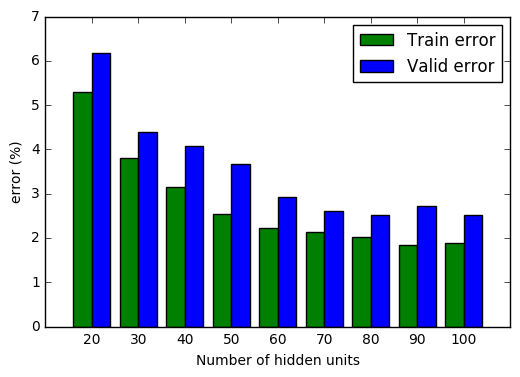

In [20]:
# Mostramos gráficamente los resultados
width = 4
pl.bar(np.array(testsnh) - width, res[1,:] * 100, color='g', width=width, label='Train error')
pl.bar(np.array(testsnh), res[0,:] * 100, width=width, label='Valid error')
pl.xlabel('Number of hidden units')
pl.ylabel('error (%)')
pl.xticks(np.array(testsnh), testsnh)
pl.legend(loc='upper right')

pl.show()

Como se puede ver los errores se estabilizan a partir de 70 unidades ocultas. Los mejores errores se dan en en 80 y 100 neuronas ocultas con un error de validación del 2,5%, que reduce aún mas el obtenido anteriormente.

# Conclusiones
## Arquitectura y parámetros más adecuados
Dado los anteriores estudios se considera la arquitectura con 80 nodos ocultos la más adecuada, ya que entre las que alcanza el mínimo error de validación obtenido (2,5%) es la mas simple. Ademas tiene un bajo error de entrenamiento (2,1%). Los parámetros aconsejados para entrenar son un ratio de aprendizaje de 0.004, una semilla de inicialización de 2 y entrenada durante 100 ciclos. Mostramos los resultados de un entrenamiento realizado especificamente con dicha arquitectura:

In [29]:
# Entrenamiento con la arquitectura más adecuada

nh = 80
net = nl.net.newlvq(minmax, nh, pc)

initlvq_randpat(net, traininput, traintarget, 2)
error = net.train(traininput, traintarget, epochs=100, show=0, goal=-1, lr=lr)

# Salvar red a fichero
net.save("optdigitsim.net")

# Cálculo de errores en %

outtrain = net.sim(traininput)
outvalid = net.sim(validinput)

terrtrain = (((traintarget - outtrain)**2).max(axis=1)).sum() / tottrain
errvalid = ((validtarget - outvalid)**2).max(axis=1)
errvalid = errvalid.sum() / totvalid

print "Train error:", errtrain * 100, "%"
print "Validation error:", errvalid * 100, "%"

Train error: 1.95326124869 %
Validation error: 2.51046025105 %


In [22]:
# Crear matrices de cruces del conjunto de entrenamiento
matcrutrain = np.zeros(100, dtype=int).reshape(10,10)
for i in range(tottrain):
    matcrutrain[int(np.dot(traintarget[i], np.arange(10))), int(np.dot(outtrain[i], np.arange(10)))] += 1

matcrutrain

array([[289,   0,   0,   0,   1,   0,   1,   0,   0,   0],
       [  0, 308,   1,   1,   0,   1,   0,   0,   0,   3],
       [  0,   2, 283,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0, 272,   0,   4,   0,   1,   1,   5],
       [  0,   3,   0,   0, 276,   0,   1,   0,   0,   3],
       [  0,   0,   0,   1,   0, 267,   1,   0,   0,   5],
       [  0,   1,   0,   0,   0,   1, 282,   0,   0,   0],
       [  0,   3,   1,   0,   0,   0,   0, 287,   0,   0],
       [  0,   5,   0,   1,   0,   1,   0,   0, 270,   2],
       [  0,   1,   0,   1,   2,   0,   0,   2,   1, 275]])

In [23]:
# Crear matrices de cruces del conjunto de validación

matcruvalid = np.zeros(100, dtype=int).reshape(10,10)
for i in range(totvalid):
    matcruvalid[int(np.dot(validtarget[i], np.arange(10))), int(np.dot(outvalid[i], np.arange(10)))] += 1

matcruvalid

array([[ 85,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  73,   0,   0,   0,   0,   0,   0,   1,   1],
       [  0,   0,  94,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 102,   0,   1,   0,   1,   1,   1],
       [  0,   1,   0,   0, 100,   0,   0,   2,   0,   1],
       [  0,   0,   0,   0,   0,  99,   0,   0,   0,   3],
       [  0,   0,   0,   0,   0,   0,  93,   0,   0,   0],
       [  0,   0,   0,   1,   1,   0,   0,  94,   0,   0],
       [  0,   6,   0,   0,   0,   0,   0,   0,  95,   0],
       [  0,   0,   0,   0,   1,   1,   0,   1,   0,  97]])

En estos resultados se muestra que el peor error por clase en el conjunto de validación se produce al confundir 6 patrones de la clase real '8' (5,9%) y clasificarlos como '1'.

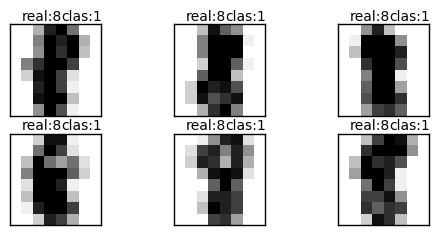

In [24]:
# Mostramos errores clase real '8'
indices = np.where(errvalid == 1)[0]
indices8 = np.where(validtarget[(indices),8] == 1)[0]

for i, ind in enumerate(indices8):
    pl.subplot(3, 3, 1 + i)
    imgplot = pl.imshow(16 - validinput[indices[ind],:].reshape(8,8))
    imgplot.set_interpolation('nearest')
    imgplot.set_cmap('gray')
    pl.text(0.5, -0.8, "real:" + str(int(np.dot(validtarget[indices[ind]], np.arange(10)))))
    pl.text(4, -0.8, "clas:" + str(int(np.dot(outvalid[indices[ind]], np.arange(10)))))
    pl.xticks([],[])
    pl.yticks([],[])

pl.show()

## Resultado para el conjunto de testeo
Con el conjunto de test se obtiene para la mejor red un error del 4,1%. Debajo se muestran también su matriz de cruce. Para leer el conjunto de test y evaluar su errores se utilizó el siguiente código:

In [25]:
# Obtener resultados para el conjunto de test
# Leer fichero de patrones de entrenamiento
patternstest = np.loadtxt("optdigits.tes", dtype=int, delimiter=',')

# Dimensiones leidas
tottest, totcolstest = patternstest.shape

tottest

1797

In [27]:
# Entradas de tests
testinput = patternstest[:, 0:totcolstest-1]

# Generar salidas deseada con formato 10 salidas binarias
testtarget = np.zeros([tottest, 10])
for i in range(tottest):
    testtarget[i, patternstest[i, -1]] = 1.0

# Obtener salidas del conjunto de test
outtest = net.sim(testinput)

# Crear matrices de cruces del conjunto test
matcrutest = np.zeros(100, dtype=int).reshape(10,10)
for i in range(tottest):
    matcrutest[int(np.dot(testtarget[i], np.arange(10))), int(np.dot(outtest[i], np.arange(10)))] += 1

matcrutest

array([[177,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 181,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   1, 173,   0,   0,   0,   0,   1,   2,   0],
       [  0,   0,   0, 170,   0,   2,   0,   3,   5,   3],
       [  0,   5,   0,   0, 175,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   1, 177,   1,   0,   0,   3],
       [  2,   0,   0,   0,   0,   1, 177,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0, 172,   0,   7],
       [  0,  10,   0,   3,   0,   2,   3,   0, 153,   3],
       [  0,   0,   0,   4,   0,   2,   0,   0,   5, 169]])

In [32]:
# Calculo de errores a través de las matrices de cruces
errtest = 1 - float(np.diag(matcrutest).sum())/tottest
print "Test error:", errtest * 100, "%"
print "Test accurracy:", (1 - errtest) * 100, "%"

Test error: 4.06232609905 %
Test accurracy: 95.9376739009 %


Este resultado final parece bastante aceptable, por ejemplo supera en 2% al mejor resultado obtenido en (Tang, Ponnuthurai, Suganthan, Yao and Qin, 2005) (93,93% de accurracy con WLDR 9d).

- (Tang, Ponnuthurai, Suganthan, Yao and Qin, 2005) Ken Tang and Ponnuthurai N. Suganthan and Xi Yao and A. Kai Qin. [Linear dimensionalityreduction using relevance weighted LDA](http://www.sciencedirect.com/science/article/pii/S0031320304003619). Pattern Recognition
vol 38 (4), April 2005, pp: 485-493